<center><a href="https://www.featuretools.com/"><img src="http://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-2000.png" width="400" height="200" /></a></center>

# Predict Taxi Trip Duration using Premium Primitives

The following tutorial illustrates using [premium primitives](http://primitives.featurelabs.com) in Featuretools to predict the duration of a taxi trip in New York City. 

In this notebook we will

1. [Load Data](#Step-1:-Load-Data)
2. [Select Primitives](#Step-2.-Selecting-Premium-Primitives)
3. [Run Featuretools](#Step-3.-Running-Featuretools)
4. [Build a model](#Step-4:-Building-the-Model)
5. [Interpret features](#Step-5:-Interpretting-Features)
6. [Apply to new data](#Step-6:-Apply-feature-engineering-and-modeling-to-new-data)

In [3]:
import featuretools as ft
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline  

## Step 1: Load Data

First, we load in a copy of the data. It is 175 MB, so it may take a few minutes to download

In [4]:
es = ft.entityset.read_entityset("s3://featurelabs-static/nyc_taxi_entityset_train.tar")

In this entity set, there is data on nearly **1.5 million taxi trips** in New York City across a several month period. For each trip, we have a handful of columns about it shown below.

With [graphviz installed](https://docs.featuretools.com/getting_started/install.html#installing-graphviz) we can generate a visualization of the entity set.

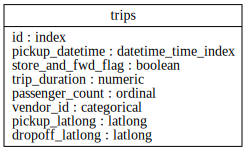

In [5]:
es.plot()

The primary data types for this problem are **geospatial** (latitude and longitude) and **temporal**. By default machine learning algorithm have a difficult time processing this data. Therefore, in order get the most out of this data, we need perform feature engineering before applying machine learning.

## Step 2. Selecting Premium Primitives

Featuretools has several premium primitives that can be used to assist with preparing this data as numeric feature vectors for machine learning. 

Below we've selected several primitives that apply to the data types in this dataset. Each of these primitives is only available in Featuretools Enterprise. To learn more about any of the primitives, click on the links to view the documentation.

* [City Block Distance](https://primitives.featurelabs.com/#CityblockDistance) -  Cars cannot travel diagonally through a city block, so this primitive can be used to give us the most accurate estimate of the distance the passenger has to travel during there trip. 


* [Lat Long To City](https://primitives.featurelabs.com/#LatLongToCity) - An important factor for the length of a trip is where it begins or ends. This primitive can convert the pick up and drop of locations to the borough e.g this trip began in Manhattan, but ends Brooklyn so we must cross the east river


* [Is In Geo Box](https://primitives.featurelabs.com/#IsInGeoBox) - Trips starting and ending by points of interesting can also be relevent. To extract this we can use a geobox to detect trips that start or end within a couple important areas in New York City that have a lot of taxi trips.

    * Area around JFK Airport - (40.62, -73.85), (40.70, -73.75)
    * Area around La Guardia Airport - (40.76, -73.89), (40.78, -73.85)
    

* [Part Of Day](https://primitives.featurelabs.com/#PartOfDay) - The traffic conditions greatly affect the duration of the trip. We know traffic varies by time of day, so we can use this primitive to extract if the trip occurs during the morning, afternoon, evening, or night.


* [Is Federal Holiday](https://primitives.featurelabs.com/#IsFirstWeekOfMonth) - A typical Monday morning may have heavy traffic going into the city, but if it is a federal holiday, the traffic conditions are likely lighter.


* [Season](https://primitives.featurelabs.com/#Season), [Quarter](https://primitives.featurelabs.com/#Quarter) - The weather outside may determine street conditions. Using these primitives we can extract the time of year. Note: this demo data only spans a few months, but these primitives may be very relevent when we expand the dataset.


## Step 3. Running Featuretools

Next, we run Featuretools using the primitives 

In [6]:
from featuretools.primitives import (CityblockDistance, LatLongToCity, IsInGeoBox, PartOfDay, 
                                     IsFederalHoliday, Season, NthWeekOfMonth, Quarter)

trans_primitives = [CityblockDistance,
                    LatLongToCity,
                    IsInGeoBox((40.62, -73.85), (40.70, -73.75)), # JFK Airport
                    IsInGeoBox((40.76, -73.89), (40.78, -73.85)), # La Guardia Airport
                    IsFederalHoliday,
                    PartOfDay,
                    Season,
                    NthWeekOfMonth,
                    Quarter]

Now we can create the feature matrix using [Deep Feature Synthesis](https://featuretools.featurelabs.com/automated_feature_engineering/afe.html)

In [7]:
fm, features = ft.dfs(entityset=es,
                      target_entity="trips",
                      trans_primitives=trans_primitives,
                      chunk_size=.1, # lowering this gives more frequent updates
                      verbose=True)

Built 16 features
Elapsed: 04:55 | Progress: 100%|██████████| Remaining: 00:00


In [8]:
fm.head(5)

,store_and_fwd_flag,trip_duration,passenger_count,vendor_id,"CITYBLOCK_DISTANCE(dropoff_latlong, pickup_latlong)",LATLONG_TO_CITY(pickup_latlong),LATLONG_TO_CITY(dropoff_latlong),"IS_IN_GEOBOX(pickup_latlong, point1=(40.62, -73.85), point2=(40.7, -73.75))","IS_IN_GEOBOX(dropoff_latlong, point1=(40.62, -73.85), point2=(40.7, -73.75))","IS_IN_GEOBOX(pickup_latlong, point1=(40.76, -73.89), point2=(40.78, -73.85))","IS_IN_GEOBOX(dropoff_latlong, point1=(40.76, -73.89), point2=(40.78, -73.85))",IS_FEDERAL_HOLIDAY(pickup_datetime),PART_OF_DAY(pickup_datetime),SEASON(pickup_datetime),NTH_WEEK_OF_MONTH(pickup_datetime),QUARTER(pickup_datetime)
id,,,,,,,,,,,,,,,,
id0000001,False,1105,1,2,4.457185,New York City,Long Island City,False,False,False,False,False,Morning,summer,3.0,2
id0000003,False,1046,5,2,1.770763,Weehawken,Hoboken,False,False,False,False,False,Morning,spring,3.0,1
id0000005,False,368,1,2,0.904869,Manhattan,Manhattan,False,False,False,False,False,Morning,spring,5.0,2
id0000008,False,303,1,1,0.967836,New York City,New York City,False,False,False,False,False,Morning,summer,3.0,2
id0000009,False,547,1,1,4.147816,Manhattan,Manhattan,False,False,False,False,False,Night,spring,2.0,2


Using the primitives above, we created many new features to feed into our machine learning algorithm. Because some of these features are categorical, we will perform categorical encoding using featurestools before continuing. 

In [9]:
fm_encoded, features_encoded = ft.encode_features(fm, features, top_n=5, verbose=True, include_unknown=False)

Encoding pass 2: 100%|██████████| 35/35 [00:00<00:00, 231.27feature/s]


## Step 4: Building the Model

After applying Featuretools, we have a feature matrix of all numeric data that is ready for machine learning. 

The final step we will do is apply a `log` transform to our trip durations. By doing this we can better distiguish short trips with in the city when training our models. We can then undo this transform after predicting.

In [10]:
X = fm_encoded.copy()
y = (X.pop('trip_duration') + 1).apply(np.log)

to validate our model, we will do a simple train/test split

In [11]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.5)

Now, we are ready to train and score our model. For the purposes of this example, we will not perform any hyper parameter tuning of our model.

In [12]:
estimator = RandomForestRegressor(n_estimators=100,
                                  n_jobs=-1,
                                  random_state=0,
                                  verbose=True)
estimator.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=True,
                      warm_start=False)

Using the trained model, we can look at the mean squared error on the test set

In [13]:
y_pred = estimator.predict(X_test)
mean_squared_error(y_pred, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.8s finished


0.2237994448285362

## Step 5: Interpretting Features

The reason why Featuretools primitives are valueable is that they transform the raw data (e.g dates, latitude and longitudes) into meaningful attributes a machine learning model can learn from. 

Now, that we have a sense for how the model peforms, let's take a look at the most important features discovered when we trained the random forest

In [33]:
importances = pd.DataFrame(zip(X.columns, estimator.feature_importances_), columns=["feature", "importance"]).sort_values("importance", ascending=False)
importances.head(10)

,feature,importance
8,"CITYBLOCK_DISTANCE(dropoff_latlong, pickup_lat...",0.797756
31,NTH_WEEK_OF_MONTH(pickup_datetime),0.040835
27,PART_OF_DAY(pickup_datetime) = Night,0.011562
7,vendor_id = 1,0.011173
6,vendor_id = 2,0.010110
1,passenger_count = 1,0.008767
28,SEASON(pickup_datetime) = spring,0.008726
24,PART_OF_DAY(pickup_datetime) = Afternoon,0.008479
2,passenger_count = 2,0.007197
30,SEASON(pickup_datetime) = summer,0.006320


As you might expect, a majority of the top features are the result of applying the premium primitives. Let's take a closer look at some features in particular

### As the distance increases, the trip duration increase

Unsuprisingly this is the most important feature. The longer the trip's distance, the longer it will take. However, we will see below this isn't always the case.

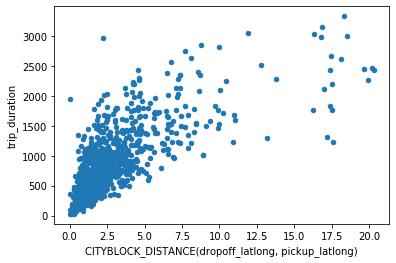

In [24]:
fm.sample(1000).plot.scatter(x='CITYBLOCK_DISTANCE(dropoff_latlong, pickup_latlong)', y ='trip_duration')

### Average trips are shorter in duration during winter, and longer during the summer

This may be because people are more likely to take a taxi when it is cold outside in New York City

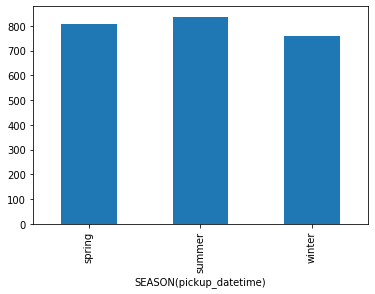

In [25]:
fm.groupby("SEASON(pickup_datetime)")["trip_duration"].mean().plot.bar()


### Trips are longer in duration on average in the afternoon even though they cover a shorter distance

This is counter to what we saw earlier. This is why it is important extract many features from your data.

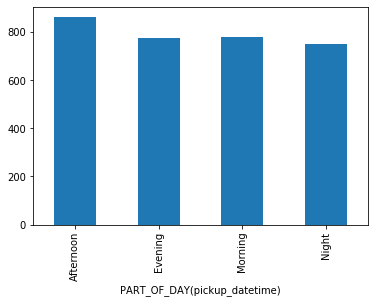

In [26]:
fm.groupby("PART_OF_DAY(pickup_datetime)")["trip_duration"].mean().plot.bar()

this is noteworthy, because afternoon trip on average are cover less distance

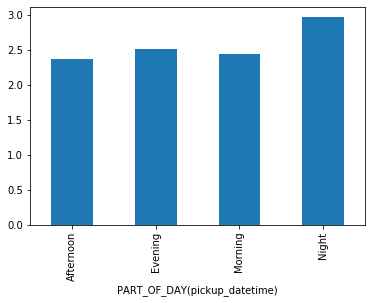

In [27]:
fm.groupby("PART_OF_DAY(pickup_datetime)")["CITYBLOCK_DISTANCE(dropoff_latlong, pickup_latlong)"].mean().plot.bar()

### Trips are shorter in time during federal holidays

This may be because fewer people are one the road when it is a holiday

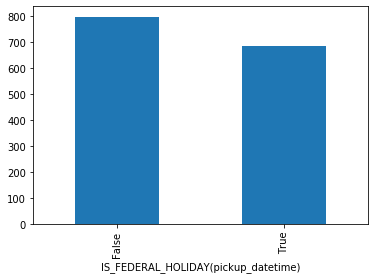

In [30]:
fm.groupby("IS_FEDERAL_HOLIDAY(pickup_datetime)")["trip_duration"].mean().plot.bar()

## Step 6: Apply feature engineering and modeling to new data

Once we are happy with our model, we can apply it to new data. Below we load in 600,000 new trips, where we don't know the duration (note: duration is no longer a column in the data).

In [32]:
es_test = ft.entityset.read_entityset("s3://featurelabs-static/nyc_taxi_entityset_test.tar")

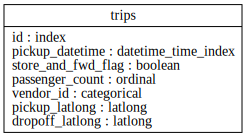

In [31]:
es_test.plot()

we can use the feature definitions that we created before to reperform feature engineering on this dataset. You can read more about saving and loading feature definitions [here](https://featuretools.featurelabs.com/guides/deployment.html#saving-features). 

In [18]:
# remove trip_duration from the features to calculate
features = [f for f in features_encoded if f.get_name() != "trip_duration"]

fm_test = ft.calculate_feature_matrix(entityset=es_test,
                                      features=features,
                                      chunk_size=.1,
                                      verbose=True)

Elapsed: 02:13 | Progress: 100%|██████████| Remaining: 00:00


with the new feature matrix in hand, we are ready to reapply our estimator that was previously trained to generate predictions

In [20]:
preds = estimator.predict(fm_test)
preds = np.exp(preds) - 1 # undo log transform
preds = pd.Series(preds, index=fm_test.index)
preds

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.0s finished


id
id0000002     982.932694
id0000006     630.908913
id0000007     903.289604
id0000017    1287.942796
id0000018    2476.906480
                ...     
id3999960     649.380241
id3999966    2040.664324
id3999967     296.574060
id3999981     803.312033
id3999997     977.224439
Length: 625134, dtype: float64

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).